# September 27

Last time, we downloaded a tree from Open Tree of Life. Then, we got the associated data. But we discovered a problem! They data are not the raw data! They are _unverifiable_ processed data. We're picking up with where we left off. 

Let's get warmed up by loading in our character matrix using dendropy. Save the matrix to a variable called amphib. Try it in the below cell.

In [176]:
# Answer follows
import dendropy
amphib = dendropy.DnaCharacterMatrix.get(
    path="../data/plethodon.phy",
    schema="phylip"
)

Subset out your !favorite! salamander.

![](img/5496126200_d596f01f80_b.jpg)

In [178]:
# Answer follows

my_taxon_sequence = amphib["Plethodon_kentucki"].symbols_as_string()
print(my_taxon_sequence)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

And finally, get your favorite locus. I chose CYTB as my favorite locus. Check to make sure it has actual data in it.

In [ ]:
#Answer
cytb1 = my_taxon_sequence[4097:5236]
cytb1

All right, good warmup. We're ready to procede now. Since we're at our computers, all warmed up, we're going to procede to do the BLAST search. Then, we will dicuss the paper.

We're getting there - we have a taxon; we have one gene. Let's see if it matches anything in NCBI. The below command is roughly what we will enter. 

In [ ]:
from Bio.Blast import NCBIWWW
from Bio import SeqIO

record = SeqIO.read("../data/sequence.fasta", format="fasta")
result_handle = NCBIWWW.qblast("blastn", "nt", record.format("fasta"))

We need to have our sequences stored in a fasta format. We will now generate a fasta-formatted sequence file to query.

In [179]:
fasta_pleth = {"Plethodon_kentucki": cytb1}
ofile = open("../data/sequence.fasta", "w")

for item in fasta_pleth.keys():
    ofile.write(">" + item + "\n" + fasta_pleth[item] + "\n")

ofile.close()

Now that we have a fasta file, let's try to query GenBank. `NCBIwww.qblast()` uses the function `qblast` to _query_ BLAST according to our nucleotide sequence.

In [1]:
from Bio.Blast import NCBIWWW
from Bio import SeqIO

record = SeqIO.read("../data/sequence.fasta", format="fasta")
result_handle = NCBIWWW.qblast("blastn", "nt", record.format("fasta"))

The data are stored in an internet file format called XML. You can print it like so:

### Note: Make a copy of your sequence object, and run operations on it. Most of the read() operations will cause you to have to redo your search.

In [9]:
print_record = result_handle
#print(print_record.read())

# Break, then reading discussion

- Key quote in Pearson paper:

`We infer homology when two sequences or structures share more similarity than would be expected by chance; when excess similarity is observed, the simplest explanation for that excess is that the two sequences did not arise independently, they arose from a common ancestor.`

- Key question:

`Thus, it is very easy to determine the distribution of scores expected by chance, and it has been observed that unrelated sequences have similarity scores that are indistinguishable from random sequence alignments.` _How can we determine similarity due to chance from similarity due to homology?_

# Let's illustrate the problem! Read the below code. Then, discuss it with a partner. Write in comments - what is this doing?

In [2]:
import random 


def rando_seq(alphabet, length):
    i = 0
    new_seq = []
    while i <= length:
        digit = random.randint(a = 0, b = (len(alphabet) - 1))
        # getting a random integer
        new_seq.append(alphabet[digit])
        # index the list, obtain the letter indicated by 
        # the random digit
        final_seq = ''.join(new_seq)
        # Go from a list to a string, no spaces between characters
        i = i + 1
    return(final_seq)

Run the code, especially if you are stuck. Look at the output!

In [182]:
alphabet = ['A', 'C', 'G', 'T']
length = 99

seq_one = rando_seq(alphabet, length)
seq_two = rando_seq(alphabet, length)


In [184]:
seq_two

'TATCGCAGAGTGATCTCTCCTCTCTTACGCTGTCTGAAGTGATAACCGCACTTTCATACCATTCTACGAACATCGTTGGCCCAACATTACAAACATTTAC'

Now, I would like you to write a function to figure out how many base pairs at a particular position in this random sequence are the same.  As a brief gut check, how many do we think will be the same?

In [3]:
# Answer follows below
def true_and_false(sequence_one, sequence_two):
    trues = []
    falses = []

    for base_one, base_two in zip(seq_one, seq_two):
        if base_one == base_two:
            trues.append("TRUE")
        else:
            falses.append("FALSE")
    return(trues, falses)


How many really are the same? What does that mean for homology searching? Run the code a couple times - is the number of base pairs that are the same in a sequence always the same? 

In [186]:
alphabet = ['A', 'C', 'G', 'T']
length = 99

seq_one = rando_seq(alphabet, length)
seq_two = rando_seq(alphabet, length)

trues, falses = true_and_false(seq_one, seq_two)

print(len(trues))
print(len(falses))

25
75


I hate small sample sizes, let's write a loop to run the code 10000 times, and save the number of "same" sites to a dataframe for each simulation.

In [10]:
# Answer follows 
import pandas as pd

alphabet = ['A', 'C', 'G', 'T']
length = 99
tries = 10000

i = 0
true_col = []
false_col = []
while i <= tries:
    seq_one = rando_seq(alphabet, length)
    seq_two = rando_seq(alphabet, length)
    trues, falses = true_and_false(seq_one, seq_two)
    true_col.append(len(trues))
    false_col.append(len(falses))
    i = i + 1

percentage_df = pd.DataFrame(
    {'Same': true_col,
     'Different': false_col})



Now, let's plot the number of "same" sites. A bar plot is fine for this.

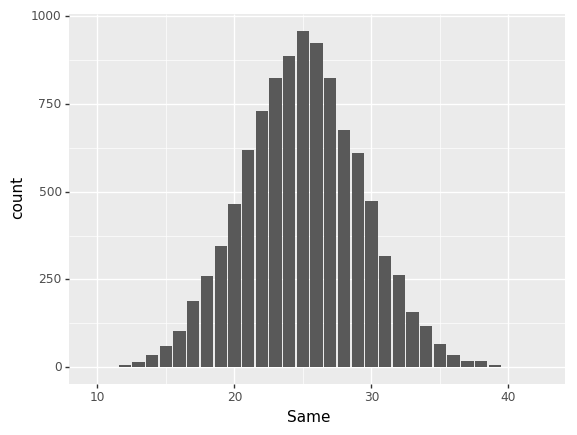

<ggplot: (-9223363279457263279)>

In [11]:
import plotnine as p9

(p9.ggplot(data=percentage_df,
           mapping=p9.aes(x='Same'))
    + p9.geom_bar()
)

### Some sites in an alignment will be the same by chance
### Some sites will be similar due to convergence environmental or life history factors 

We want to:

- Minimize false positives (non-homologs with significant scores; Type I errors)
- Find true homologs
- Minimize false negatives (homologs with non-significant scores; Type II errors)

How do we do this? 

- Develop a distribution of expected similarities
    - Common rule of thumb is that 30% of above sequence identity is fine. Based on what we've done above, is that fine?
    - E-values ("Expect" value): Excess homology compared to random. We take that distribution we plotted above, and transform it into a value. 0.001 generally taken to be a 'good' E-Value.
- Scale our expectations with size



In [3]:
save_file = open("results.xml", "w")
save_file.write(result_handle.read())
save_file.close()

Take a look at this file. This is very useful and easy-to-read output. 

In [4]:
from Bio.Blast import NCBIXML

parsed = NCBIXML.read(open("results.xml"))

The `parsed` object will contain references to the:
- Search that was performed
- Items that were found

Try tab-completing the below to look at some of the options.

In [ ]:
parsed.

One particular feature that is likely to be of interest is the `alignments` feature. Take a look at one alignments' stats:

In [5]:
print(parsed.alignments[0])

gi|125380686|gb|DQ994948.1| Plethodon kentucki voucher RH 66693 cytochrome b (cytb) gene, partial cds; mitochondrial
           Length = 625



We can even take a look at multiple hits - what were they? To what species do they belong? 

In [6]:
alignment_set = parsed.alignments
for individual_alignment in alignment_set:
    print(individual_alignment)

gi|125380686|gb|DQ994948.1| Plethodon kentucki voucher RH 66693 cytochrome b (cytb) gene, partial cds; mitochondrial
           Length = 625

gi|51979883|gb|AY728222.1| Plethodon petraeus mitochondrion, complete genome
           Length = 19235

gi|125380683|gb|DQ994946.1| Plethodon jordani voucher JB 201-73-01 cytochrome b (cytb) gene, partial cds; mitochondrial
           Length = 644

gi|125380685|gb|DQ994947.1| Plethodon jordani voucher JB 201-67w-01 cytochrome b-like (cytb) gene, partial sequence; mitochondrial
           Length = 649

gi|125380736|gb|DQ994973.1| Plethodon petraeus voucher RWV S21-B cytochrome b (cytb) gene, partial cds; mitochondrial
           Length = 630

gi|125380641|gb|DQ994924.1| Plethodon chlorobryonis voucher JJW 1807 cytochrome b (cytb) gene, partial cds; mitochondrial
           Length = 649

gi|125380761|gb|DQ994986.1| Plethodon shermani voucher JJW 1741 cytochrome b (cytb) gene, partial cds; mitochondrial
           Length = 649

gi|125380664|gb|DQ994

Let's load up the tree from last class! Have a look at a couple of the taxa that have come up in your BLAST search. They seem to make a certain amount of sense - we are generally retrieving hits from related species.

In [7]:
import pandas as pd
import dendropy

pd.options.display.max_colwidth = 1000000
salamanders = pd.read_json("salamanders.json")
salamanders

pd.options.display.max_colwidth = 1000000
newick_tree = salamanders.newick.to_string(index=False)
#View our Tree
newick_tree

"(((((((((Plethodon_chlorobryonis_ott57750,Plethodon_variolatus_ott162442),Plethodon_chattahoochee_ott161611),(((Plethodon_cylindraceus_ott128947,Plethodon_teyahalee_ott208588),(Plethodon_aureolus_ott367241,Plethodon_cheoah_ott942947)),Plethodon_glutinosus_ott534317)),((Plethodon_montanus_ott128931,Plethodon_metcalfi_ott128944),(Plethodon_amplus_ott128937,Plethodon_meridianus_ott942954))),(((((((Plethodon_mississippi_ott128934,Plethodon_kiamichi_ott229842),((((Plethodon_savannah_ott128940,Plethodon_ocmulgee_ott162445),Plethodon_grobmani_ott145459),Plethodon_kisatchie_ott596896),(Plethodon_albagula_ott162448,Plethodon_sequoyah_ott596892))),Plethodon_shermani_ott942942),Plethodon_yonahlossee_ott515343),Plethodon_jordani_ott515340),Plethodon_kentucki_ott942949),(Plethodon_caddoensis_ott162451,(Plethodon_ouachitae_ott385557,Plethodon_fourchensis_ott732220)))),Plethodon_petraeus_ott366877),(((((Plethodon_ventralis_ott128950,Plethodon_dorsalis_ott841810),Plethodon_angusticlavius_ott229834),P

Load the Newick tree into IcyTree, and locate your taxon with the `Search` function. Look at the taxa you see in your BLAST hits. Do you feel like it's likely that these hits are discovering real homology?

![](img/Twitter.png)

But given what we have read about BLAST, do we feel good about what we did? Pearson noted some best practices for BLAST. He notes that we should use protein. Did we do this? Did we specify any sort of E-Value constraint?

## Homework

1. Simulate two nucleotide sequences (2 pts)

2. Make a BLAST query of one of them. Put the code in the cell below. In the Markdown cell below that one, paste in a couple of the hits (i.e, what did your random sequence match?????). (5 pts)

3. Look at the documentation for the [NCBIWWW.qblast](http://biopython.org/DIST/docs/api/Bio.Blast.NCBIWWW-module.html) function. What are two arguments or parameters we could manipulate to more closely follow Bill Pearson's suggestions? Why would these be good values to manipulate? (3 pts)

Download this notebook with your answers and email to me by 10 am Tuesday.

In [10]:
from Bio.Blast import NCBIXML

for gb_record in print_record:
    # now do something with the record
    print(gb_record.seq)

AttributeError: 'str' object has no attribute 'seq'